<a href="https://colab.research.google.com/github/BlackBoxTechnic/ImageRecognition_NeuralNetwork/blob/main/ImageRecML-MNIST-NoLibraries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240629%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240629T094041Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D65228d3ec2dd2e9a35d4283ce6fe08134810eedd74d58345ef72134e47e845332c5f7f0ba7aa0c761ce0eaa1fb10b81fbe9f1df5a6751101e130486a139202a8d5453e21cc276a4797a5f63ebd006d02978318697e97a55edacb99606acb3a294a2e5699a0dd20a63381f24fd7460329af30a8a6a0530f6447c162ca8d084c542f020c2f5b873f4953e9cfb2201fb6078a486c97bfeff784d101441b32f92d91c3d54f2b077fcfc4556b46e0b5a79d6900f1beef6c76beb394a5757cc3cd080437c57d1608015a6d813df887b0bb0e04677c7484c1b5944c7c30125008f6155a70522d7e8fe40f74514598bb08ed692f65167136dba25aa1ae9c8c6f4a20ff92'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [23]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [24]:
Y_train

array([6, 1, 5, ..., 8, 7, 3])

In [25]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return W1, b1, W2, b2


def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    Z -= np.max(Z, axis=0)  # Subtract max value for numerical stability
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [26]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [27]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[0 0 3 ... 0 5 3] [6 1 5 ... 8 7 3]
0.10990243902439024
Iteration:  10
[2 2 3 ... 3 2 3] [6 1 5 ... 8 7 3]
0.36897560975609756
Iteration:  20
[6 2 0 ... 3 2 3] [6 1 5 ... 8 7 3]
0.4923658536585366
Iteration:  30
[6 2 0 ... 8 7 3] [6 1 5 ... 8 7 3]
0.5505609756097561
Iteration:  40
[6 2 0 ... 8 7 3] [6 1 5 ... 8 7 3]
0.5939512195121951
Iteration:  50
[6 2 0 ... 8 7 3] [6 1 5 ... 8 7 3]
0.6606341463414634
Iteration:  60
[1 1 5 ... 8 7 3] [6 1 5 ... 8 7 3]
0.7775365853658537
Iteration:  70
[1 1 5 ... 8 7 3] [6 1 5 ... 8 7 3]
0.7999024390243903
Iteration:  80
[1 1 5 ... 8 7 3] [6 1 5 ... 8 7 3]
0.814
Iteration:  90
[1 1 5 ... 8 7 3] [6 1 5 ... 8 7 3]
0.8242926829268292
Iteration:  100
[1 1 5 ... 8 7 3] [6 1 5 ... 8 7 3]
0.8330487804878048
Iteration:  110
[1 1 5 ... 8 7 3] [6 1 5 ... 8 7 3]
0.8397073170731707
Iteration:  120
[1 1 8 ... 8 7 3] [6 1 5 ... 8 7 3]
0.8445853658536585
Iteration:  130
[1 1 8 ... 8 7 3] [6 1 5 ... 8 7 3]
0.8485609756097561
Iteration:  140
[1 1 8 ... 8

In [28]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [6]
Label:  6


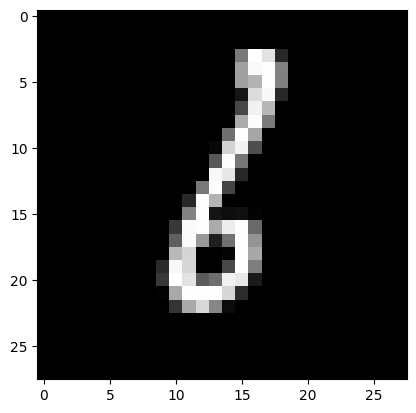

Prediction:  [1]
Label:  1


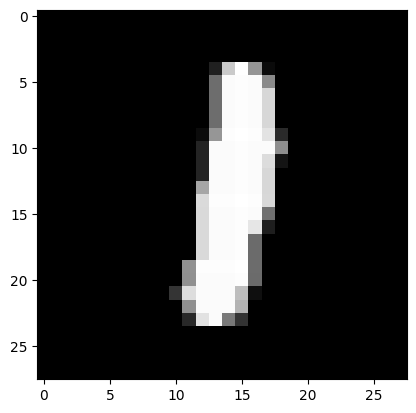

Prediction:  [8]
Label:  5


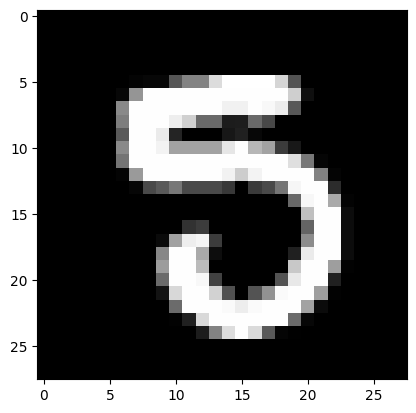

Prediction:  [0]
Label:  0


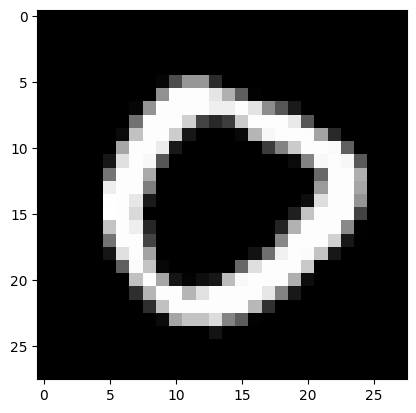

In [29]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [30]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[8 9 2 2 5 3 2 7 8 0 2 2 8 6 2 6 5 6 2 6 6 7 5 1 4 5 3 5 5 1 9 3 2 2 6 9 0
 5 0 7 9 3 8 1 8 3 7 4 8 5 1 8 1 0 3 2 3 1 1 9 4 1 2 1 4 1 5 9 2 1 7 7 4 3
 8 5 5 4 2 2 3 9 6 7 9 1 8 9 5 7 8 1 9 3 2 1 4 7 9 2 8 3 0 0 0 9 4 6 4 8 7
 4 6 6 9 4 2 3 9 1 9 8 4 3 6 9 4 7 5 7 2 7 6 4 0 7 9 9 7 6 2 7 3 6 1 7 6 6
 5 9 9 7 5 2 1 9 6 6 4 1 7 1 1 7 2 7 7 0 1 7 4 7 0 3 0 4 1 5 4 5 9 1 8 0 9
 3 7 5 7 4 8 1 5 6 1 6 8 7 2 8 9 7 8 9 5 4 5 6 1 4 0 0 2 8 5 9 8 6 6 8 4 3
 8 0 5 3 9 1 0 1 7 4 8 5 1 3 9 5 8 4 3 4 3 1 1 2 4 9 3 1 3 7 8 1 7 2 8 5 0
 0 4 1 6 1 2 2 4 2 6 7 9 8 0 4 8 8 2 6 2 8 7 1 7 4 9 1 0 8 4 8 1 2 0 7 8 2
 3 0 8 1 8 9 8 8 3 9 4 2 6 5 3 3 6 3 4 4 1 4 1 6 1 8 1 5 3 3 3 7 0 5 4 5 5
 8 5 0 9 0 8 6 7 4 8 3 8 8 3 2 3 7 9 2 6 8 2 8 9 0 3 1 9 8 0 3 6 3 8 8 4 4
 2 2 1 9 2 6 8 2 1 9 4 4 1 4 7 8 0 3 4 6 4 9 6 4 4 2 5 2 7 2 7 5 0 7 4 6 8
 4 3 1 5 3 1 9 1 5 5 3 2 3 0 6 0 6 7 9 1 6 2 6 4 8 8 4 9 6 8 4 9 2 6 8 1 3
 0 0 4 7 2 1 7 4 5 6 3 6 2 1 4 0 6 7 4 2 0 8 4 3 9 8 3 6 1 4 5 3 9 3 4 3 8
 7 1 2 1 8 7 9 3 3 3 8 9 

0.907